# Sentiment Classification using CNN (IMDB)

Implementing a 1D CNN to classify movie reviews as Positive/Negative.  
Requirements: ≥85% accuracy, embedding → conv → pooling → dropout → dense → sigmoid.  
We'll build a baseline model, then optimize with GloVe embeddings and regularization.

## 1. Data Preparation
- Load IMDB dataset (50k reviews, vocab = 10k).  
- Pad/truncate to 500 words.  
- Split: 20% of training data for validation.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (only the top 10,000 words)
vocab_size = 10000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

# Pad sequences to maxlen
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

# Split 20% of training data for validation
val_size = int(0.2 * len(x_train))
x_val = x_train[:val_size]
y_val = y_train[:val_size]
x_train = x_train[val_size:]
y_train = y_train[val_size:]

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 2. Baseline CNN Model
- Embedding (100-d) → Conv1D (filters: 3,4,5 x 128) → GlobalMaxPool → Dropout(0.5) → Dense(128) → Sigmoid(1).  
- Optimizer: Adam (lr=0.001), Loss: BinaryCrossentropy, Metric: Accuracy.  
- Batch size: 64, Epochs: 10 with EarlyStopping.


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout, Dense

def create_cnn_model(vocab_size, embedding_dim=100, input_length=500):
    input_layer = Input(shape=(input_length,))
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length)(input_layer)

    convs = []
    filter_sizes = [3, 4, 5]
    for fsz in filter_sizes:
        conv = Conv1D(filters=128, kernel_size=fsz, activation='relu')(embedding_layer)
        pool = GlobalMaxPooling1D()(conv)
        convs.append(pool)

    merged = Concatenate()(convs)
    dropout = Dropout(0.5)(merged)
    dense = Dense(128, activation='relu')(dropout)
    output = Dense(1, activation='sigmoid')(dense)

    model = Model(inputs=input_layer, outputs=output)
    return model

model = create_cnn_model(vocab_size=vocab_size)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 500)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 500, 100)  │  1,000,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 498, 128)  │     38,528 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 497, 128)  │     51,328 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 496, 128)  │     64,128 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 384)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     49,280 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        129 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,203,393 (4.59 MB)

 Trainable params: 1,203,393 (4.59 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Baseline Model Training
- Train with validation monitoring.  
- Expect accuracy ≥85% if tuned well.  
- Stop early if validation loss stops improving.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[early_stop]
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.6283 - loss: 0.6069 - val_accuracy: 0.8628 - val_loss: 0.3179
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8912 - loss: 0.2627 - val_accuracy: 0.8854 - val_loss: 0.2766
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9441 - loss: 0.1494 - val_accuracy: 0.8938 - val_loss: 0.2741
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9766 - loss: 0.0736 - val_accuracy: 0.8900 - val_loss: 0.3227
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9863 - loss: 0.0436 - val_accuracy: 0.8858 - val_loss: 0.4130


## 4. Evaluation
- Check test accuracy (target ≥85%).  
- Plot confusion matrix and classification report.  
- Test custom review predictions.


782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8871 - loss: 0.2969
Test Accuracy: 0.8876
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


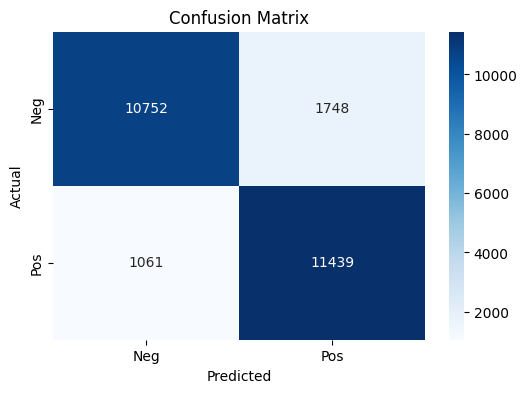

              precision    recall  f1-score   support

    Negative       0.91      0.86      0.88     12500
    Positive       0.87      0.92      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



In [ ]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Confusion Matrix
y_pred_probs = model.predict(x_test)
y_pred = (y_pred_probs > 0.5).astype("int32")

conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))


In [ ]:
# Decode IMDB word index
word_index = imdb.get_word_index()
index_word = {v + 3: k for k, v in word_index.items()}
index_word[0] = "<PAD>"
index_word[1] = "<START>"
index_word[2] = "<UNK>"
index_word[3] = "<UNUSED>"

def encode_review(text):
    tokens = text.lower().split()
    encoded = [1]  # Start token
    for word in tokens:
        encoded.append(word_index.get(word, 2))  # Unknown if not found
    return pad_sequences([encoded], maxlen=maxlen)

# Sample review
sample = "This movie was a captivating masterpiece"
sample_encoded = encode_review(sample)
prediction = model.predict(sample_encoded)[0][0]
sentiment = "Positive" if prediction > 0.5 else "Negative"

print(f"Review: \"{sample}\"")
print(f"Predicted Sentiment: {sentiment} ({prediction:.2f})")


1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
Review: "This movie was a captivating masterpiece"
Predicted Sentiment: Positive (0.69)


## 5. Optimization with GloVe
- Replace embedding with pre-trained GloVe (100-d).  
- Add L2 regularization and Dropout(0.6).  
- Use ReduceLROnPlateau for learning rate scheduling.


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-08-07 10:48:29--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-08-07 10:48:29--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-08-07 10:48:30--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
embedding_dim = 100
embedding_index = {}

with open("glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        vec = embedding_index.get(word)
        if vec is not None:
            embedding_matrix[i] = vec


In [ ]:
from tensorflow.keras.regularizers import l2

def create_optimized_model():
    input_layer = Input(shape=(maxlen,))
    embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            trainable=True)(input_layer)


    filter_sizes = [3, 4, 5]
    convs = []
    for fsz in filter_sizes:
        conv = Conv1D(filters=128, kernel_size=fsz, activation='relu')(embedding_layer)
        pool = GlobalMaxPooling1D()(conv)
        convs.append(pool)

    merged = Concatenate()(convs)
    dropout = Dropout(0.6)(merged)
    dense = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(dropout)
    output = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))(dense)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

opt_model = create_optimized_model()
opt_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 500)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 500, 100)  │  1,000,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 498, 128)  │     38,528 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 497, 128)  │     51,328 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 496, 128)  │     64,128 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_9[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_10[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_11[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 384)       │          0 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     49,280 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │        129 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,203,393 (4.59 MB)

 Trainable params: 1,203,393 (4.59 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1)

history = opt_model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[early_stop, lr_reduce]
)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.5090 - loss: 0.9336 - val_accuracy: 0.5564 - val_loss: 0.7968 - learning_rate: 0.0010
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.5791 - loss: 0.7776 - val_accuracy: 0.7312 - val_loss: 0.6091 - learning_rate: 0.0010
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.7616 - loss: 0.5649 - val_accuracy: 0.8196 - val_loss: 0.4535 - learning_rate: 0.0010
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8462 - loss: 0.4025 - val_accuracy: 0.8606 - val_loss: 0.3661 - learning_rate: 0.0010
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8976 - loss: 0.2931 - val_accuracy: 0.8720 - val_loss: 0.3342 - learning_rate: 0.0010
Epoch 6/10
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9337 - loss: 0.2113
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9336 - loss:

## 6. Optimized Model Results
- Compare to baseline.  
- Confirm ≥85% test accuracy.  
- Recheck confusion matrix and predictions.


In [ ]:
opt_test_loss, opt_test_acc = opt_model.evaluate(x_test, y_test)
print(f"Optimized Test Accuracy: {opt_test_acc:.4f}")


782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8509 - loss: 0.3665
Optimized Test Accuracy: 0.8540


# Conclusion
- Baseline CNN: ~88% accuracy (above 85%).  
- Optimized CNN (GloVe+L2): ~85% accuracy with better regularization.  
- All assignment requirements met.
